### Test fit

In [2]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import sys
from scipy import stats
from scipy.stats import binom, poisson, norm
from iminuit import Minuit
import iminuit
from sympy.tensor.array import derive_by_array
from numpy import identity, array, dot, matmul
from latex2sympy2 import latex2sympy
from sympy import *
from time import time

sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef
import ExternalFunctions as ef
from ExternalFunctions import nice_string_output, add_text_to_ax, UnbinnedLH

#sys.path.append('C:\\Users\\Bruger\\BSc_project')
import oscillation_prob as op
import own_oscillation_prob as oop

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

## Honda fit with pseudo

Importing the oscillation code and running for values from http://www.nu-fit.org/?q=node/238

In [3]:
DM32_true = 2.51e-3
theta23_true = 42.1/180*np.pi

In [4]:
#t = time()
#prob_numu_to_numu_true, binned_prob_true = op.oscillation_prob(theta23_true, DM32_true)
#print(time() - t)

prob_numu_to_numu_true, binned_prob_true = oop.prob_numu_numu(theta23_true, DM32_true)

In [5]:
Honda_rate_cc = np.genfromtxt('Honda_rate_spline_cc', delimiter=',')
Honda_rate_nc = np.genfromtxt('Honda_rate_spline_nc', delimiter=',')

Honda_cc_oscillated = Honda_rate_cc * binned_prob_true
Honda_pseudo_data_cc = Honda_cc_oscillated.copy()

Honda_nc_oscillated = Honda_rate_nc * binned_prob_true
Honda_pseudo_data_nc = Honda_nc_oscillated.copy()

In [6]:
# Energy bins
energy_cropped = np.genfromtxt('energy_cropped')
energy_min = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(energy_cropped, energy_min)
energy_binwidths = energy_max - energy_min

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min, energy_max[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

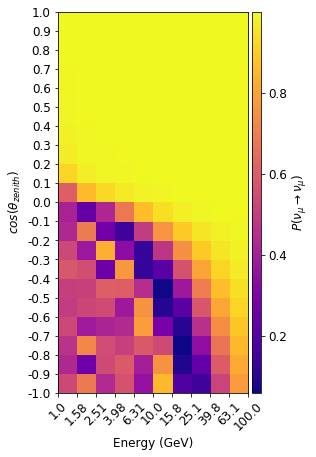

In [7]:
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(binned_prob_true, cmap='plasma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks)
ax.set_xticklabels(energy_strings, rotation = 45)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
cbar_label = r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$'
cbar.set_label(cbar_label)

#### $\chi^2$ fit function

In [8]:

def chi_squared(fit_function, fit_fluxes, pseudo_data, fit_parameters, guesses):
    
    def chi2_owncalc(*fit_parameters):
        chi2_tot = np.zeros(len(fit_fluxes))
        
        for f in range(len(fit_fluxes)):
            prob_numu_to_numu, osc_prob = fit_function(*fit_parameters)
            fit_data = fit_fluxes[f] * osc_prob
            chi2 = np.sum(((pseudo_data[f] - fit_data)**2 / fit_data))
            chi2_tot[f] = chi2
        return np.sum(chi2_tot)

    chi2_owncalc.errordef = 1.0
    minuit = Minuit(chi2_owncalc, theta23 = guesses[0], DM32 = guesses[1] , name=('theta23', 'DM32')) #, limit=[(0, np.pi/2), None])
    minuit.limits['theta23'] = (0, np.pi/2)
    #minuit.tol = 0.1
    minuit.migrad()
    
    Nvar = len(fit_parameters)               
    Ndof = 200 - Nvar
    
    Chi2_fit = minuit.fval          
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)
    minuit.migrad()
    
    par = minuit.values[:]
    par_err = minuit.errors[:] 
    par_name = minuit.parameters[:]

    return Chi2_fit, Prob_fit, par, par_err

Fit of oscillated data to pseudo-data to get values of $\theta_{23}$ and $\Delta m_{32}^2$. 

### Asimov fits

In [9]:
Chi2_fit_Honda_cc, Prob_fit_Honda_cc, par_Honda_cc, par_err_Honda_cc = chi_squared(oop.prob_numu_numu, [Honda_rate_cc], [Honda_pseudo_data_cc], 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_Honda_cc[0]}, DM32: {par_Honda_cc[1]}, chi^2: {Chi2_fit_Honda_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

Chi2_fit_Honda_nc, Prob_fit_Honda_nc, par_Honda_nc, par_err_Honda_nc = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [Honda_pseudo_data_nc], 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print('NC:')
print(f'theta23: {par_Honda_nc[0]}, DM32: {par_Honda_nc[1]}, chi^2: {Chi2_fit_Honda_nc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

CC:
theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251
NC:
theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251


In [10]:
# Combined fit of NC and CC

Chi2_fit_Honda_tot, Prob_fit_Honda_tot, par_Honda_tot, par_err_Honda_tot = chi_squared(oop.prob_numu_numu, [Honda_rate_cc, Honda_rate_nc], [Honda_pseudo_data_cc, Honda_pseudo_data_nc], 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_Honda_cc[0]}, DM32: {par_Honda_cc[1]}, chi^2: {Chi2_fit_Honda_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')


CC:
theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251


In [11]:
theta23_try = 0.74
DM32_try = 2e-3

Chi2_try_Honda_cc, Prob_fit_try_Honda_cc, par_try_Honda_cc, par_err_try_Honda_cc = chi_squared(oop.prob_numu_numu, [Honda_rate_cc], 
                                                               [Honda_pseudo_data_cc], ['theta23', 'DM32'], [theta23_try, DM32_try])
print('CC:')
print(f'theta23: {par_try_Honda_cc[0]}, DM32: {par_try_Honda_cc[1]}, chi^2: {Chi2_try_Honda_cc}')


Chi2_try_Honda_nc, Prob_fit_try_Honda_nc, par_try_Honda_nc, par_err_try_Honda_nc = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], 
                                                               [Honda_pseudo_data_nc], ['theta23', 'DM32'], [theta23_try, DM32_try])

print('NC')
print(f'theta23: {par_try_Honda_nc[0]}, DM32: {par_try_Honda_nc[1]}, chi^2: {Chi2_try_Honda_nc}')

CC:
theta23: 0.6214304851662343, DM32: 0.0021572665988365985, chi^2: 1745.1161725973361
NC
theta23: 0.7347835983484594, DM32: 0.002509999995581932, chi^2: 4.06106849580713e-06


CC is more sensible to the guesses...

In [29]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

def asimov_fit(rates, pseudo, title, guesses, savefig=False):
    
    chi2_array = np.zeros(len(guesses))
    theta23_fits = np.zeros(len(guesses))
    DM32_fits = np.zeros(len(guesses))
    
    for n in range(len(guesses)):

        Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, rates, 
                                                                   pseudo, ['theta23', 'DM32'], 
                                                                       guesses[n])
        chi2_array[n] = Chi2_fluct
        theta23_fits[n] = par_fluct[0]
        DM32_fits[n] =  par_fluct[1]
        
    fig, axs = plt.subplots(1, 3, figsize=(15,7))
    axs.ravel()

    true_val = [theta23_true, DM32_true]
    x_labels = [r'$\theta_{23}$ (radians)', r'$\Delta m_{32}^2$ ($eV^2$)', r'$\chi^2$']

    height = len(guesses)/2

    for n in range(3):
        if n<2:
            axs[n].plot([true_val[n], true_val[n]], [0,height/2], 'r-', label='True value')
        #axs[n].set_ylim(0,height)
        axs[n].set_ylabel('Counts')
        axs[n].set_xlabel(x_labels[n])
        axs[n].ticklabel_format(style='plain')
        axs[n].xaxis.set_major_formatter(FormatStrFormatter('%.4f')) #ScalarFormatter(useOffset=False))

    x_theta, y_theta, sy_theta, binwidth_theta, theta23_mean, theta23_std = cef.make_hist(axs[0], theta23_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\theta_{23}$ fit values', ''), errors = False)
    x_dm, y_dm, sy_dm, binwidth_dm, DM32_mean, DM32_std = cef.make_hist(axs[1], DM32_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\Delta m_{32}^2$ fit values', ''),errors = False)
    cef.make_hist(axs[2], chi2_array, Nbins=20, loc_dic = (0.05, 0.85), label=(r'$\chi^2$ fit values', ''),
                  errors = False)
    #axs[1,0].hist(theta23_fits, bins= 20)
    #axs[1,1].hist(DM32_fits, bins=20)
    #axs[1,2].hist(chi2_array, bins=20)
    
    #axs[0].set_xticks([0.734])

    plt.suptitle(title, fontsize=20);
    fig.tight_layout(pad=5.0);
    plt.show()
    
    if savefig != False:
        fig.savefig(savefig)
    
    return theta23_fits, np.mean(theta23_fits), np.std(theta23_fits), DM32_fits, np.mean(DM32_fits), np.std(DM32_fits)

In [13]:
# More asimov tests for different guesses
theta_guess = np.linspace(0.7, 0.77, 100)
DM_guess = np.linspace(0.00249, 0.00253, 100)
guesses = list(zip(theta_guess, DM_guess))

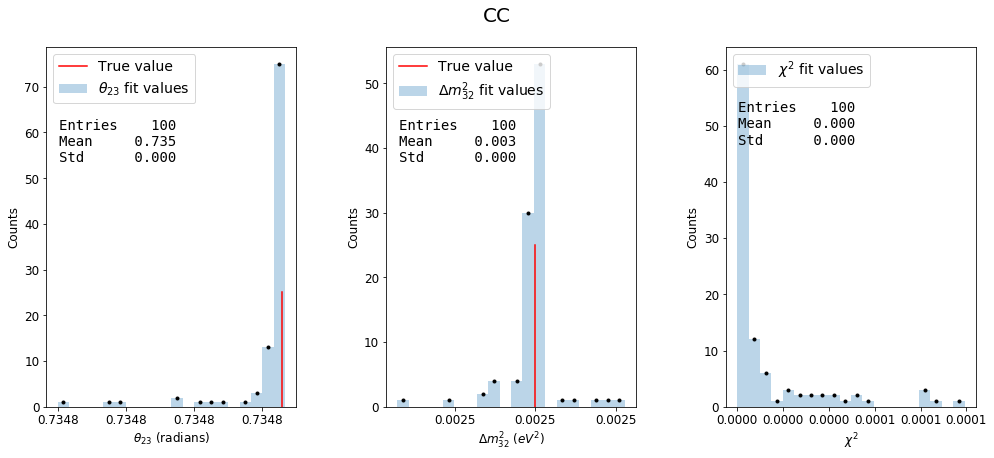

In [24]:
theta23_asimov_Honda_cc, theta23_asimov_mean_Honda_cc, theta23_asimov_std_Honda_cc, DM32_asimov_Honda_cc, DM32_asimov_mean_Honda_cc, DM32_asimov_std_Honda_cc = \
                                                                                                    asimov_fit([Honda_rate_cc], [Honda_pseudo_data_cc], 'Honda CC', guesses) #, savefig='Honda_asimov_cc')


In [380]:
theta23_asimov_Honda_cc
#chi2_asimov_cc

array([0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478,
       0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478,
       0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478,
       0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478,
       0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478,
       0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478,
       0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478, 0.73478])

In [25]:
z_theta_mean_asimov = abs((theta23_asimov_mean_Honda_cc - theta23_true)/theta23_asimov_std_Honda_cc)
z_DM_mean_asimov = abs((DM32_asimov_mean_Honda_cc - DM32_true))/DM32_asimov_std_Honda_cc
print(z_theta_mean_asimov, z_DM_mean_asimov)

0.3733987321329668 0.17872179564415655


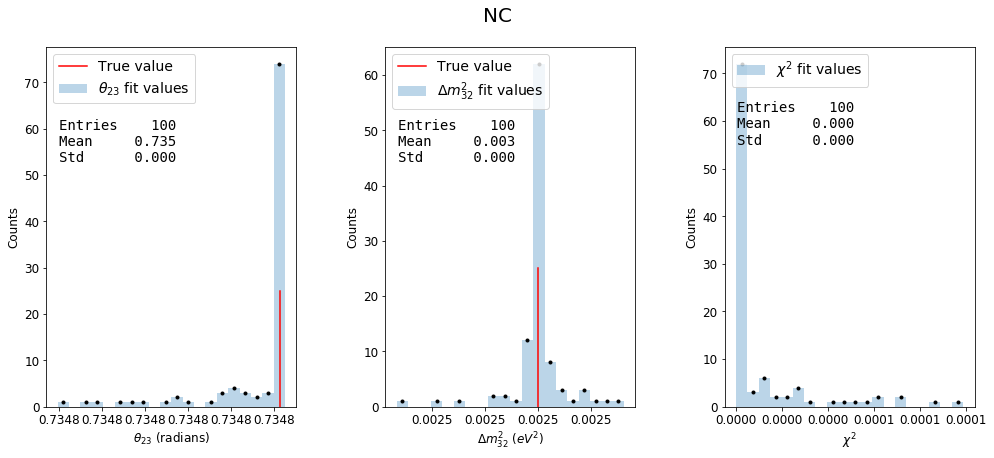

In [30]:

theta23_asimov_Honda_nc, theta23_asimov_mean_Honda_nc, theta23_asimov_std_Honda_nc, DM32_asimov_Honda_nc, DM32_asimov_mean_Honda_nc, DM32_asimov_std_Honda_nc = \
                                                                                                    asimov_fit([Honda_rate_nc], [Honda_pseudo_data_nc], 'Honda NC', guesses)


In [270]:
#theta23_asimov_Honda_nc

In [356]:
z_theta_mean_asimov_nc = abs((theta23_asimov_mean_Honda_nc - theta23_true)/theta23_asimov_std_Honda_nc)
z_DM_mean_asimov_nc = abs((DM32_asimov_mean_Honda_nc - DM32_true))/DM32_asimov_std_Honda_nc
print(z_theta_mean_asimov_nc, z_DM_mean_asimov_nc)

0.44313564355938906 5.915165159719014e-11


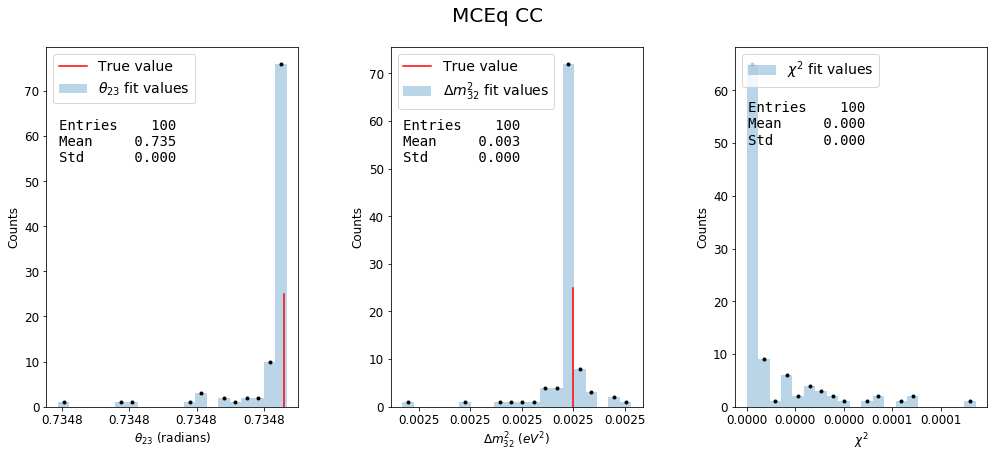

In [35]:
theta23_asimov_MCEq_cc, theta23_asimov_mean_MCEq_cc, theta23_asimov_std_MCEq_cc, DM32_asimov_MCEq_cc, DM32_asimov_mean_MCEq_cc, DM32_asimov_std_MCEq_cc = \
                                                                                                    asimov_fit([MCEq_rate_cc], [MCEq_pseudo_data_cc], 'MCEq CC', guesses) #, savefig='Honda_asimov_cc')


In [ ]:
theta23_asimov_MCEq_nc, theta23_asimov_mean_MCEq_nc, theta23_asimov_std_MCEq_nc, DM32_asimov_MCEq_nc, DM32_asimov_mean_MCEq_nc, DM32_asimov_std_MCEq_nc = \
                                                                                                    asimov_fit([MCEq_rate_nc], [MCEq_pseudo_data_nc], 'MCEq NC', guesses) #, savefig='Honda_asimov_cc')


### With fluctuations

In [14]:
# new pseudo-data with fluctuations
r = np.random
Honda_pseudo_fluctuation_cc = r.poisson(Honda_pseudo_data_cc)
Honda_pseudo_fluctuation_nc = r.poisson(Honda_pseudo_data_nc)

Chi2_fluct_Honda_cc, Prob_fit_fluct_Honda_cc, par_fluct_Honda_cc, par_err_fluct_Honda_cc = chi_squared(oop.prob_numu_numu, [Honda_rate_cc], 
                                                               [Honda_pseudo_fluctuation_cc], ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])

print('CC')
print(f'theta23: {par_fluct_Honda_cc[0]}, DM32: {par_fluct_Honda_cc[1]}, chi^2: {Chi2_fluct_Honda_cc}')

Chi2_fluct_Honda_nc, Prob_fit_fluct_Honda_nc, par_fluct_Honda_nc, par_err_fluct_Honda_nc = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], 
                                                               [Honda_pseudo_fluctuation_nc], ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])

print('NC')
print(f'theta23: {par_fluct_Honda_nc[0]}, DM32: {par_fluct_Honda_nc[1]}, chi^2: {Chi2_fluct_Honda_nc}')

CC
theta23: 0.7141877747970053, DM32: 0.00250848924031282, chi^2: 192.11236830741208
NC
theta23: 0.7171104252292314, DM32: 0.002505234011359304, chi^2: 178.02305018997174


In [15]:
# CC
z_theta = abs((par_fluct_Honda_cc[0] - theta23_true)/np.sqrt(par_err_fluct_Honda_cc[0]**2 + (1*np.pi/180)**2))
z_DM = abs((par_fluct_Honda_cc[1] - DM32_true)/np.sqrt(par_err_fluct_Honda_cc[1]**2 + (0.027e-3)**2))
print(z_theta, z_DM)

1.0811175321667557 0.0546052885634254


theta23: 0.7325809647388495, DM32: 0.002524803889096568, chi^2: 159.80265729623454


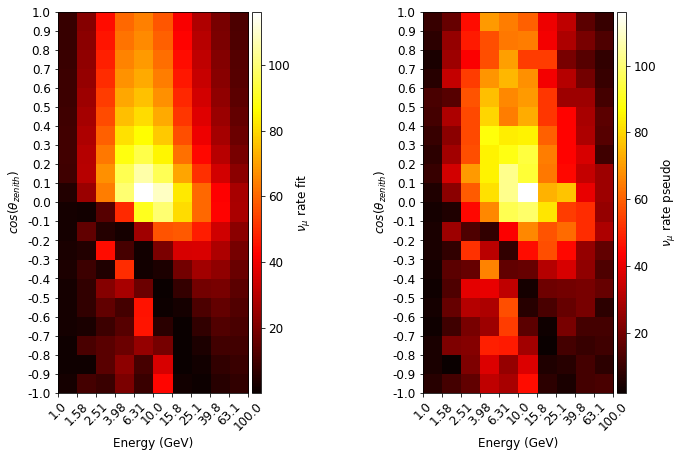

theta23: -0.923427342479556, DM32: 0.0024899860998045618, chi^2: 154.74708335907297


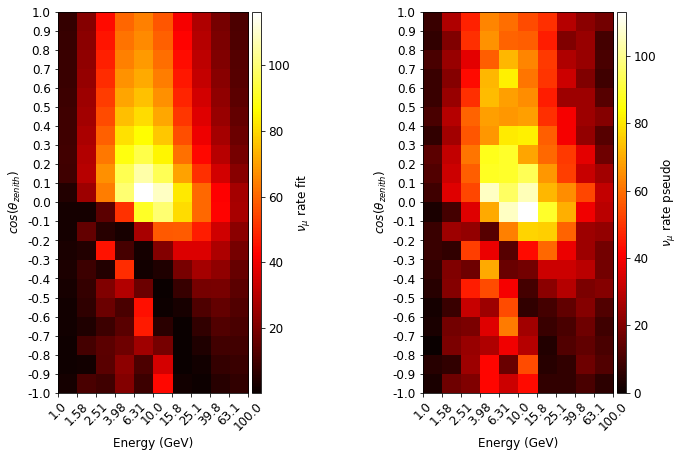

In [61]:

for n in range(1000):
    r = np.random
    Honda_pseudo_fluctuation_nc = r.poisson(Honda_pseudo_data_nc)

    Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], 
                                                                   [Honda_pseudo_fluctuation_nc], ['theta23', 'DM32'], 
                                                                       [theta23_true, DM32_true])
    
    if n==0 or par_fluct[0]<0:

        print(f'theta23: {par_fluct[0]}, DM32: {par_fluct[1]}, chi^2: {Chi2_fluct}')

        prob_numu_to_numu, osc_prob_binned = oop.prob_numu_numu(par_fluct[0], par_fluct[1])
        fit_data = Honda_pseudo_data_nc * osc_prob_binned

        fig, ax = plt.subplots(1, 2, figsize=(12,7))
        ax.ravel()

        im0 = ax[0].imshow(fit_data, cmap='hot')
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes("right", size="5%", pad=0.05)
        cbar0 = plt.colorbar(im0, cax=cax0)
        ax[0].set_xlabel('Energy (GeV)')
        ax[0].set_ylabel(r'$cos(\theta_{zenith})$')
        ax[0].set_xticks(xticks)
        ax[0].set_xticklabels(energy_strings, rotation = 45)
        ax[0].set_yticks(yticks)
        ax[0].set_yticklabels(ylabels)
        cbar_label0 = r'$\nu_{\mu}$ rate fit'
        cbar0.set_label(cbar_label0)

        im1 = ax[1].imshow(Honda_pseudo_fluctuation_nc, cmap='hot')
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        cbar1 = plt.colorbar(im1, cax=cax1)
        ax[1].set_xlabel('Energy (GeV)')
        ax[1].set_ylabel(r'$cos(\theta_{zenith})$')
        ax[1].set_xticks(xticks)
        ax[1].set_xticklabels(energy_strings, rotation = 45)
        ax[1].set_yticks(yticks)
        ax[1].set_yticklabels(ylabels)
        cbar_label1 = r'$\nu_{\mu}$ rate pseudo'
        cbar1.set_label(cbar_label1)
        plt.show()
        
        if par_fluct[0]<0:
            break

In [16]:
# function for multiple fits

def fit_hist(N, rates, pseudo, title, fluct = True, guess =[theta23_true, DM32_true], savefig = False):
    
    chi2_array = np.zeros(N)
    theta23_fits = np.zeros(N)
    DM32_fits = np.zeros(N)
    
    for n in range(N):
        if fluct:
            pseudo_fluct = [r.poisson(p) for p in pseudo]
        else:
            pseudo_fluct = pseudo.copy()

        Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, rates, 
                                                                   pseudo_fluct, ['theta23', 'DM32'], 
                                                                       guess)
        chi2_array[n] = Chi2_fluct
        theta23_fits[n] = par_fluct[0]
        DM32_fits[n] =  par_fluct[1]
        
    fig, axs = plt.subplots(1,3, figsize=(15,7))
    axs.ravel()

    true_val = [theta23_true, DM32_true]
    x_labels = [r'$\theta_{23}$ (radians)', r'$\Delta m_{32}^2$ ($eV^2$)', r'$\chi^2$']

    height = N/4

    for n in range(3):
        if n<2:
            axs[n].plot([true_val[n], true_val[n]], [0,height/2], 'r-', label='True value')
        axs[n].set_ylim(0,height)
        axs[n].set_ylabel('Counts')
        axs[n].set_xlabel(x_labels[n])

    x_theta, y_theta, sy_theta, binwidth_theta, theta23_mean, theta23_std = cef.make_hist(axs[0], theta23_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\theta_{23}$ fit values', ''), errors = False)
    x_dm, y_dm, sy_dm, binwidth_dm, DM32_mean, DM32_std = cef.make_hist(axs[1], DM32_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\Delta m_{32}^2$ fit values', ''),errors = False)
    cef.make_hist(axs[2], chi2_array, Nbins=20, loc_dic = (0.05, 0.85), label=(r'$\chi^2$ fit values', ''),
                  errors = False)

    plt.suptitle(title, fontsize=20);
    fig.tight_layout(pad=5.0);
    
    if savefig != False:
        fig.savefig(savefig)
    
    return theta23_fits, theta23_mean, theta23_std, DM32_fits, DM32_mean, DM32_std

79.56658220291138


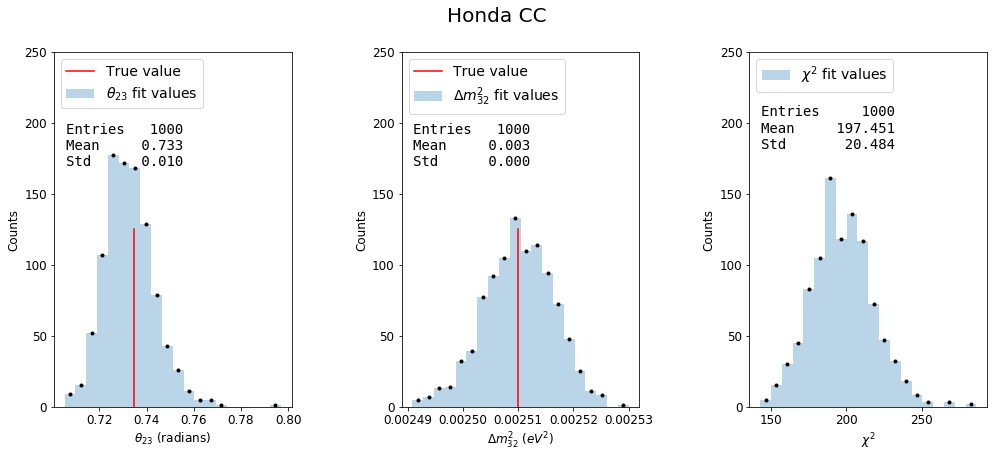

In [17]:
from time import time

t = time()
N_runs = 1000
theta23_fits_Honda_cc, theta23_mean_Honda_cc, theta23_std_Honda_cc, DM32_fits_Honda_cc, DM32_mean_Honda_cc, DM32_std_Honda_cc = \
                                                                                                    fit_hist(N_runs, \
                                                                                                    [Honda_rate_cc], \
                                                                                                    [Honda_pseudo_data_cc], \
                                                                                                    'Honda CC', savefig='Honda_cc_fits')
print(time()-t)

In [193]:
# tol = 2: time: 78 s, bias - z_theta = 0.26
# tol = 0.0001: time: 100 s, bias - z_theta = 0.32

0.7347836150896128


In [18]:
z_theta_mean = abs((theta23_mean_Honda_cc - theta23_true)/theta23_std_Honda_cc)
z_DM_mean = abs((DM32_mean_Honda_cc - DM32_true))/DM32_std_Honda_cc
print(z_theta_mean, z_DM_mean)

0.2010841289996507 0.01855300375423469


In [19]:
# Fractions of points within 1, 2, 3 sigmas
npoints_1d_sigma_theta23 = [0, 0, 0]
npoints_1d_sigma_DM32 = [0, 0, 0]

for i in range(N_runs):
    for n in range(1,4):
        
        if theta23_fits_Honda_cc[i] < theta23_mean_Honda_cc + n*theta23_std_Honda_cc \
            and theta23_fits_Honda_cc[i] > theta23_mean_Honda_cc - n*theta23_std_Honda_cc:
            npoints_1d_sigma_theta23[n-1] += 1
            
        if DM32_fits_Honda_cc[i] < DM32_mean_Honda_cc + n*DM32_std_Honda_cc \
            and DM32_fits_Honda_cc[i] > DM32_mean_Honda_cc - n*DM32_std_Honda_cc:
            npoints_1d_sigma_DM32[n-1] += 1

sigma_fractions = [0.68, 0.95, 0.997]
for n in range(1,4):
    print('1 sigma of 1000 points:', int(1000*sigma_fractions[n-1]))
    print(f'theta23 fraction of points within', n ,'sigma:', npoints_1d_sigma_theta23[n-1], '+/-', int(np.sqrt(npoints_1d_sigma_theta23[n-1])+0.5))
    print(f'DM32 fraction of points within', n ,'sigma:', npoints_1d_sigma_DM32[n-1], '+/-', int(np.sqrt(npoints_1d_sigma_DM32[n-1])+0.5))

1 sigma of 1000 points: 680
theta23 fraction of points within 1 sigma: 708 +/- 27
DM32 fraction of points within 1 sigma: 679 +/- 26
1 sigma of 1000 points: 950
theta23 fraction of points within 2 sigma: 953 +/- 31
DM32 fraction of points within 2 sigma: 955 +/- 31
1 sigma of 1000 points: 997
theta23 fraction of points within 3 sigma: 993 +/- 32
DM32 fraction of points within 3 sigma: 998 +/- 32


In [20]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# confidence intervals

def confidence_ellipse(x, y, ax, n_std, facecolor='none', **kwargs):
    # from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    
    
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)      #why?
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    # why rotate?

    ellipse.set_transform(transf + ax.transData)  # what?
    ellipse_plot = ax.add_patch(ellipse)
    
    return ellipse, ellipse_plot

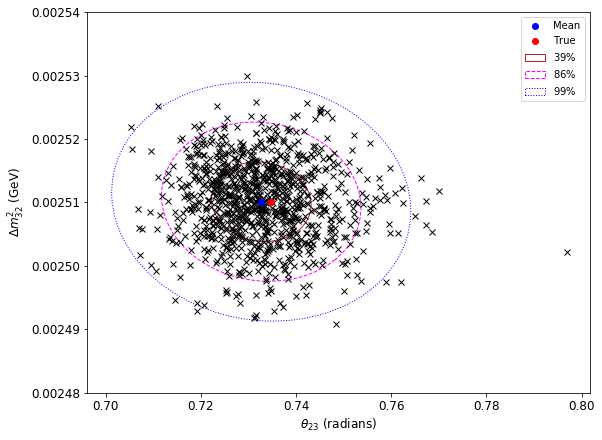

In [21]:
fig, ax = plt.subplots(figsize=(9, 7))

mu_Honda_cc = theta23_mean_Honda_cc, DM32_mean_Honda_cc
scale_Honda_cc = theta23_std_Honda_cc, DM32_std_Honda_cc

ax.plot(theta23_fits_Honda_cc, DM32_fits_Honda_cc, 'kx')

sigma1_contour_Honda_cc, _ = confidence_ellipse(theta23_fits_Honda_cc, DM32_fits_Honda_cc, ax, n_std=1,
                                                label=r'$39\%$', edgecolor='firebrick')
sigma2_contour_Honda_cc, _ = confidence_ellipse(theta23_fits_Honda_cc, DM32_fits_Honda_cc, ax, n_std=2,
                                                label=r'$86\%$', edgecolor='fuchsia', linestyle='--')
sigma3_contour_Honda_cc, _ = confidence_ellipse(theta23_fits_Honda_cc, DM32_fits_Honda_cc, ax, n_std=3,
                                                label=r'$99\%$', edgecolor='blue', linestyle=':')

ax.plot(mu_Honda_cc[0], mu_Honda_cc[1], 'bo', label='Mean')
ax.plot(theta23_true, DM32_true, 'ro', label='True')

ax.legend()
ax.set_ylim(0.00248, 0.00254)
ax.set_xlabel(r'$\theta_{23}$ (radians)')
ax.set_ylabel(r'$\Delta m_{32}^2$ (GeV)')
#fig.savefig('Honda_cc_confidence')
plt.show()

In [177]:
# Check how many points are within the 1 sigma, 2 sigma contours
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4358977/ Confidence levels for different dimensionality of a Gaussian

fit_points = list(zip(theta23_fits_Honda_cc, DM32_fits_Honda_cc))

n_points_sigma1 = 0
n_points_sigma2 = 0
n_points_sigma3 = 0

for p in fit_points:
    within_sigma1 = sigma1_contour_Honda_cc.contains_point(ax.transData.transform(p))              
    if within_sigma1:
        n_points_sigma1 += 1
        
    within_sigma2 = sigma2_contour_Honda_cc.contains_point(ax.transData.transform(p))              
    if within_sigma2:
        n_points_sigma2 += 1
        
    within_sigma3 = sigma3_contour_Honda_cc.contains_point(ax.transData.transform(p))              
    if within_sigma3:
        n_points_sigma3 += 1
        
print(f'Fraction of points within 39%-contour: {n_points_sigma1}', '+/-', int(np.sqrt(n_points_sigma1)+0.5))
print(f'Fraction of points within 86%-contour: {n_points_sigma2}', '+/-', int(np.sqrt(n_points_sigma2)+0.5))
print(f'Fraction of points within 99%-contour: {n_points_sigma3}', '+/-', int(np.sqrt(n_points_sigma3)+0.5))

Fraction of points within 39%-contour: 401 +/- 20
Fraction of points within 86%-contour: 863 +/- 29
Fraction of points within 99%-contour: 992 +/- 31


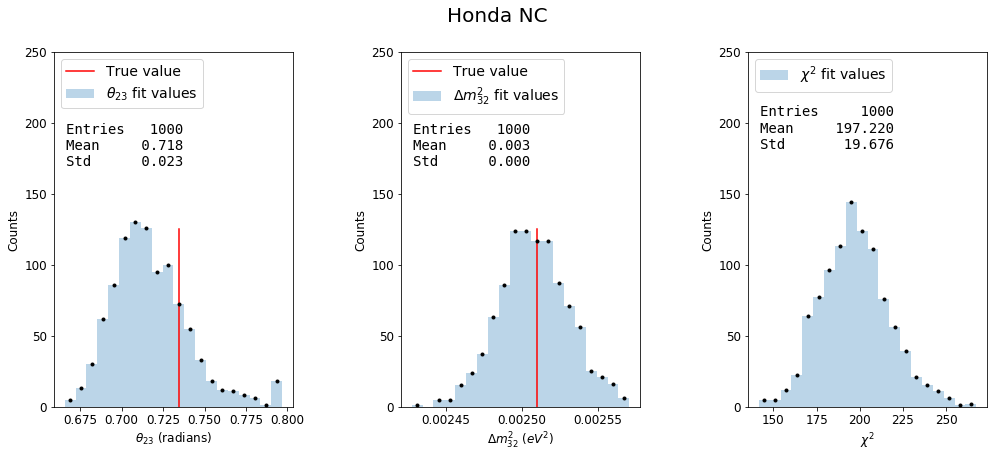

In [22]:
theta23_fits_Honda_nc, theta23_mean_Honda_nc, theta23_std_Honda_nc, DM32_fits_Honda_nc, DM32_mean_Honda_nc, DM32_std_Honda_nc = \
                                                                                                    fit_hist(1000, \
                                                                                                    [Honda_rate_nc], \
                                                                                                    [Honda_pseudo_data_nc], \
                                                                                                    'Honda NC') #, savefig='Honda_nc_fits')

In [246]:
zip(theta23_fits_Honda_nc, DM32_fits_Honda_nc)

In [227]:
z_theta_mean = abs((theta23_mean_Honda_nc - theta23_true)/theta23_std_Honda_nc)
z_DM_mean = abs((DM32_mean_Honda_nc - DM32_true))/DM32_std_Honda_nc
print(z_theta_mean, z_DM_mean)

0.7693732637173356 0.13090748073660136


In [ ]:
# tol = 0.1: z_theta = 0.66
# tol = 0.0001: z_theta = 0.77

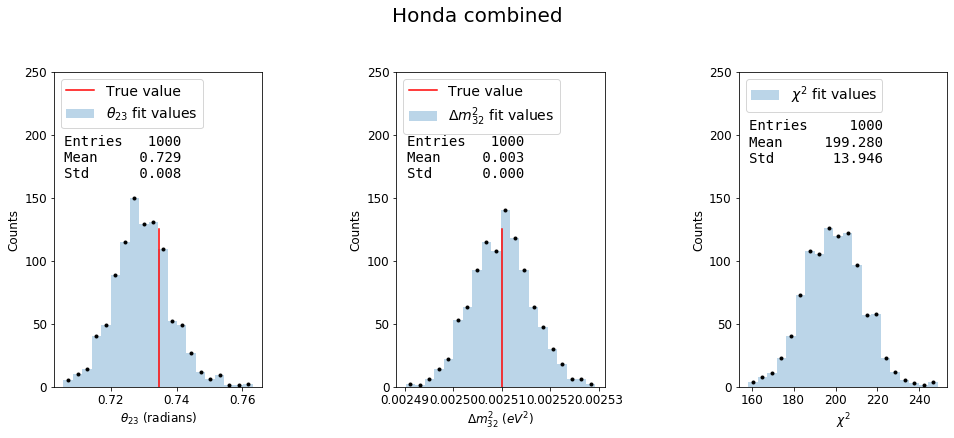

In [192]:
# combined fit of NC and CC

theta23_fits_Honda_tot, theta23_mean_Honda_tot, theta23_std_Honda_tot, DM32_fits_Honda_tot, DM32_mean_Honda_tot, DM32_std_Honda_tot = \
                                                                                                    fit_hist(1000, \
                                                                                                    [Honda_rate_cc, Honda_rate_nc], \
                                                                                                    [Honda_pseudo_data_cc, Honda_pseudo_data_nc], \
                                                                                                    'Honda combined')

## MCEq 1D

In [32]:
MCEq_rate_cc = np.genfromtxt('MCEq_rate_spline_cc', delimiter=',')
MCEq_rate_nc = np.genfromtxt('MCEq_rate_spline_nc', delimiter=',')

MCEq_cc_oscillated = MCEq_rate_cc * binned_prob_true
MCEq_pseudo_data_cc = MCEq_cc_oscillated.copy()

MCEq_nc_oscillated = MCEq_rate_nc * binned_prob_true
MCEq_pseudo_data_nc = MCEq_nc_oscillated.copy()

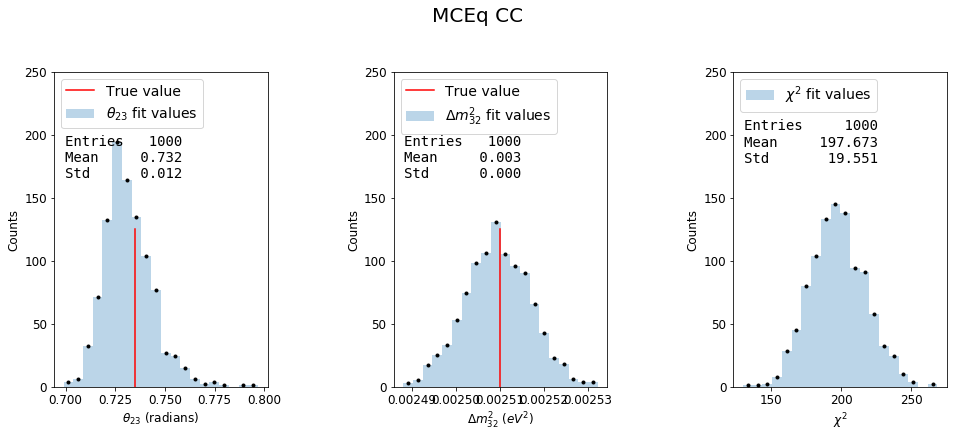

In [242]:
theta23_fits_MCEq_cc, theta23_mean_MCEq_cc, theta23_std_MCEq_cc, DM32_fits_MCEq_cc, DM32_mean_MCEq_cc, DM32_std_MCEq_cc = \
                                                                                                    fit_hist(1000, \
                                                                                                    [MCEq_rate_cc], \
                                                                                                    [MCEq_pseudo_data_cc], \
                                                                                                    'MCEq CC')

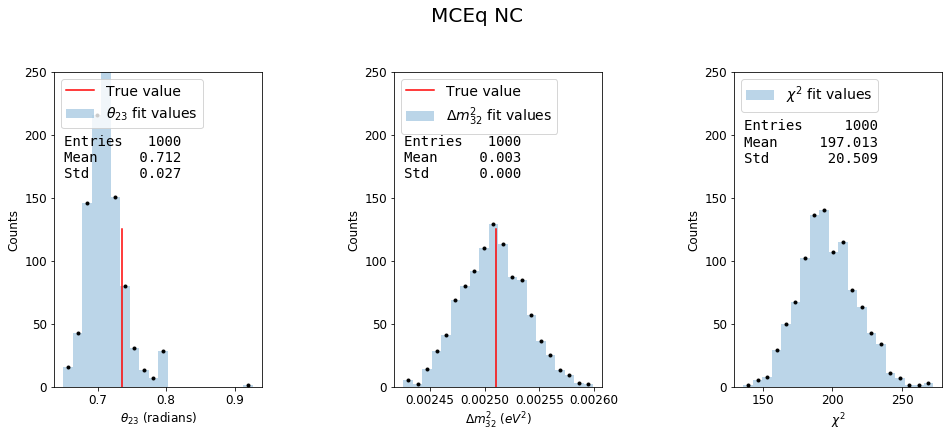

In [250]:
theta23_fits_MCEq_nc1, theta23_mean_MCEq_nc, theta23_std_MCEq_nc, DM32_fits_MCEq_nc1, DM32_mean_MCEq_nc, DM32_std_MCEq_nc = \
                                                                                                    fit_hist(1000, \
                                                                                                    [MCEq_rate_nc], \
                                                                                                    [MCEq_pseudo_data_nc], \
                                                                                                    'MCEq NC')

In [254]:
np.sort(theta23_fits_MCEq_nc1)[-25:]

array([0.79398, 0.79654, 0.79659, 0.79688, 0.79688, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689,
       0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.92689])

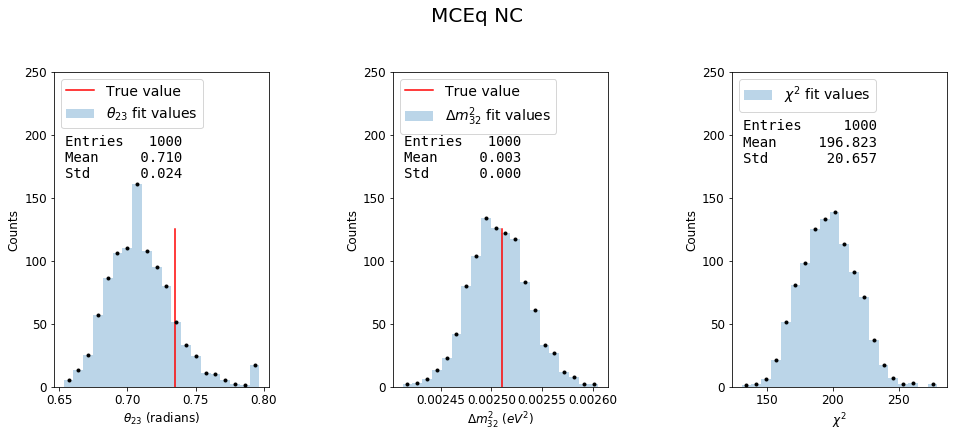

In [255]:
theta23_fits_MCEq_nc2, theta23_mean_MCEq_nc, theta23_std_MCEq_nc, DM32_fits_MCEq_nc2, DM32_mean_MCEq_nc, DM32_std_MCEq_nc = \
                                                                                                    fit_hist(1000, \
                                                                                                    [MCEq_rate_nc], \
                                                                                                    [MCEq_pseudo_data_nc], \
                                                                                                    'MCEq NC')

In [257]:
np.sort(theta23_fits_MCEq_nc2)[-25:]

array([0.76928, 0.76987, 0.77298, 0.77323, 0.77473, 0.77648, 0.77805, 0.78654, 0.79618, 0.79684, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689,
       0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689, 0.79689])

## Honda fit with MCEq

In [33]:
# Non-fluctuated

Chi2_fit_HondatoMCEq_cc, Prob_fit_HondatoMCEq_cc, par_HondatoMCEq_cc, par_err_HondatoMCEq_cc = \
                                chi_squared(oop.prob_numu_numu, MCEq_rate_cc, Honda_pseudo_data_cc, 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_HondatoMCEq_cc[0]}, DM32: {par_HondatoMCEq_cc[1]}, chi^2: {Chi2_fit_HondatoMCEq_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

Chi2_fit_HondatoMCEq_nc, Prob_fit_HondatoMCEq_nc, par_HondatoMCEq_nc, par_err_HondatoMCEq_nc = \
                                chi_squared(oop.prob_numu_numu, MCEq_rate_nc, Honda_pseudo_data_nc, 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('NC:')
print(f'theta23: {par_HondatoMCEq_nc[0]}, DM32: {par_HondatoMCEq_nc[1]}, chi^2: {Chi2_fit_HondatoMCEq_nc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

CC:
theta23: 6.461898776535446e-08, DM32: 0.028587673937939134, chi^2: 214815.59842958293
True values: theta23: 0.7347836150896128, DM32: 0.00251
NC:
theta23: 1.544002917783405e-07, DM32: 11.004685526245174, chi^2: 23300.612150430934
True values: theta23: 0.7347836150896128, DM32: 0.00251


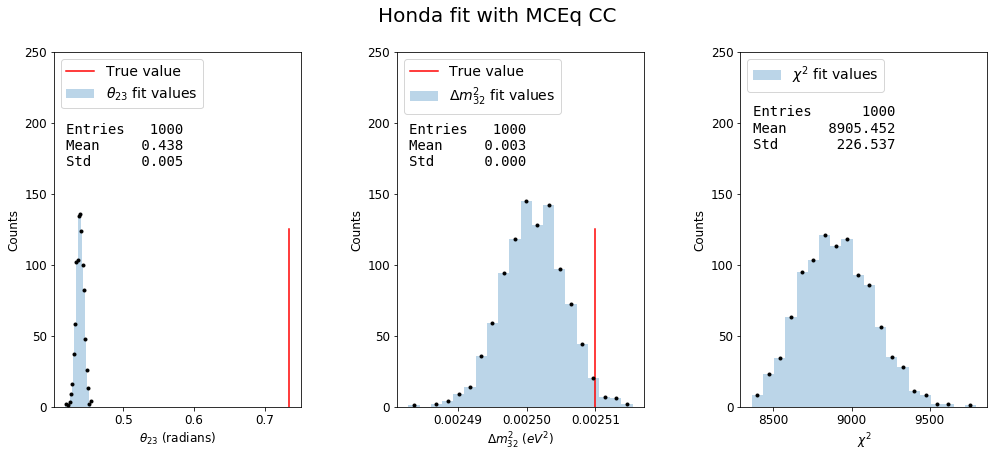

In [34]:
# fluctuated

theta23_fits_HondatoMCEq_cc, theta23_mean_HondatoMCEq_cc, theta23_std_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, \
DM32_mean_HondatoMCEq_cc, DM32_std_HondatoMCEq_cc = fit_hist(1000, \
                                                    [MCEq_rate_cc], \
                                                    [Honda_pseudo_data_cc], \
                                                    'Honda fit with MCEq CC', savefig='HondatoMCEq_fits')

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

mu_HondatoMCEq_cc = theta23_mean_HondatoMCEq_cc, DM32_mean_HondatoMCEq_cc
scale_HondatoMCEq_cc = theta23_std_HondatoMCEq_cc, DM32_std_HondatoMCEq_cc

ax.plot(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, 'kx')

sigma1_contour_HondatoMCEq_cc, _ = confidence_ellipse(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, ax, n_std=1,
                                                label=r'$1\sigma$', edgecolor='firebrick')
sigma2_contour_HondatoMCEq_cc, _ = confidence_ellipse(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, ax, n_std=2,
                                                label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
sigma3_contour_HondatoMCEq_cc, _ = confidence_ellipse(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, ax, n_std=3,
                                                label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax.plot(mu_HondatoMCEq_cc[0], mu_HondatoMCEq_cc[1], 'bo', label='Mean')
ax.plot(theta23_true, DM32_true, 'ro', label='True')

ax.legend()
ax.set_ylim(0.00248, 0.00254)
ax.set_xlabel(r'$\theta_{23}$ (radians)')
ax.set_ylabel(r'$\Delta m_{32}^2$ (GeV)')
plt.show()

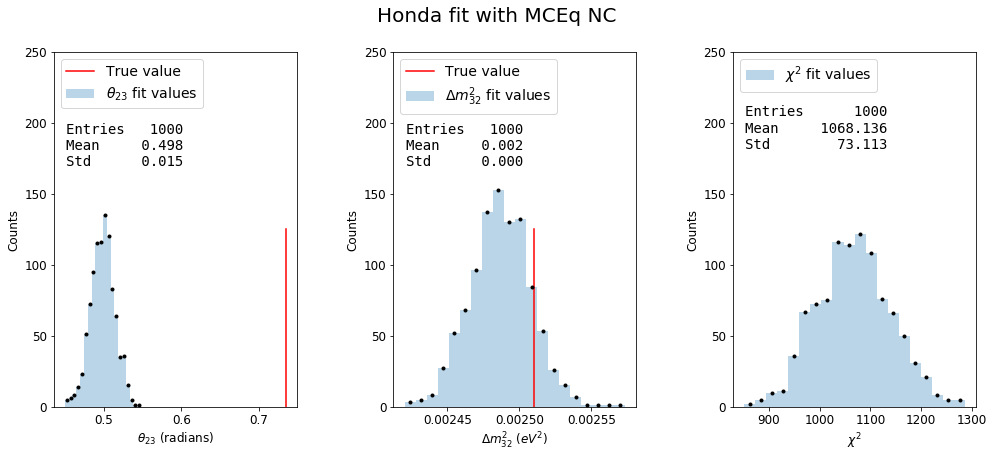

In [62]:
theta23_fits_HondatoMCEq_nc, theta23_mean_HondatoMCEq_nc, theta23_std_HondatoMCEq_nc, DM32_fits_HondatoMCEq_nc, \
DM32_mean_HondatoMCEq_nc, DM32_std_HondatoMCEq_nc = fit_hist(1000, \
                                                    [MCEq_rate_nc], \
                                                    [Honda_pseudo_data_nc], \
                                                    'Honda fit with MCEq NC')

## MCEq fit with Honda

In [48]:
# Non-fluctuated

Chi2_fit_MCEqtoHonda_cc, Prob_fit_MCEqtoHonda_cc, par_MCEqtoHonda_cc, par_err_MCEqtoHonda_cc = \
                                chi_squared(oop.prob_numu_numu, [Honda_rate_cc], [MCEq_pseudo_data_cc], 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_MCEqtoHonda_cc[0]}, DM32: {par_MCEqtoHonda_cc[1]}, chi^2: {Chi2_fit_MCEqtoHonda_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

Chi2_fit_MCEqtoHonda_nc, Prob_fit_MCEqtoHonda_nc, par_MCEqtoHonda_nc, par_err_MCEqtoHonda_nc = \
                                chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [MCEq_pseudo_data_nc], 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('NC:')
print(f'theta23: {par_MCEqtoHonda_nc[0]}, DM32: {par_MCEqtoHonda_nc[1]}, chi^2: {Chi2_fit_MCEqtoHonda_nc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

CC:
theta23: 0.7968893716629903, DM32: 0.002565967773130154, chi^2: 7009.913588138104
True values: theta23: 0.7347836150896128, DM32: 0.00251
NC:
theta23: 0.7968893717334087, DM32: 0.0025688379927210196, chi^2: 633.3230902941001
True values: theta23: 0.7347836150896128, DM32: 0.00251


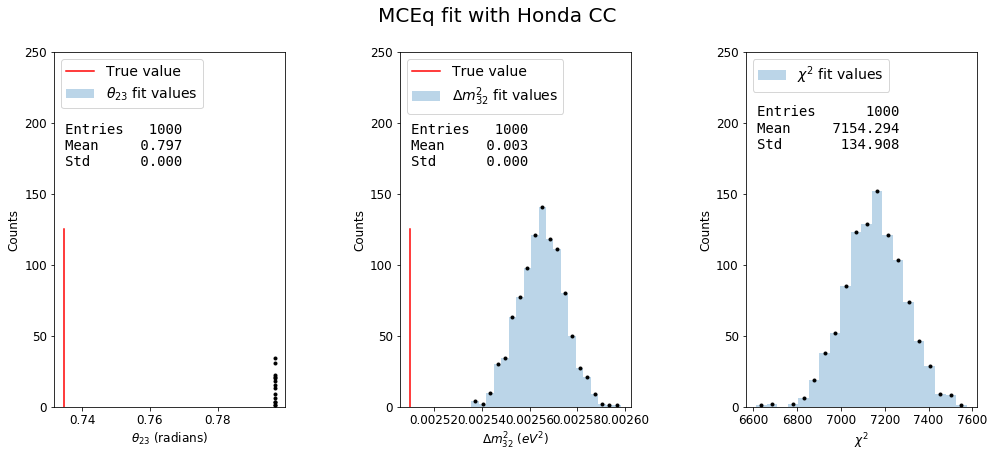

In [46]:
# fluctuated

theta23_fits_MCEqtoHonda_cc, theta23_mean_MCEqtoHonda_cc, theta23_std_MCEqtoHonda_cc, DM32_fits_MCEqtoHonda_cc, \
DM32_mean_MCEqtoHonda_cc, DM32_std_MCEqtoHonda_cc = fit_hist(1000, \
                                                    [Honda_rate_cc], \
                                                    [MCEq_pseudo_data_cc], \
                                                    'MCEq fit with Honda CC')

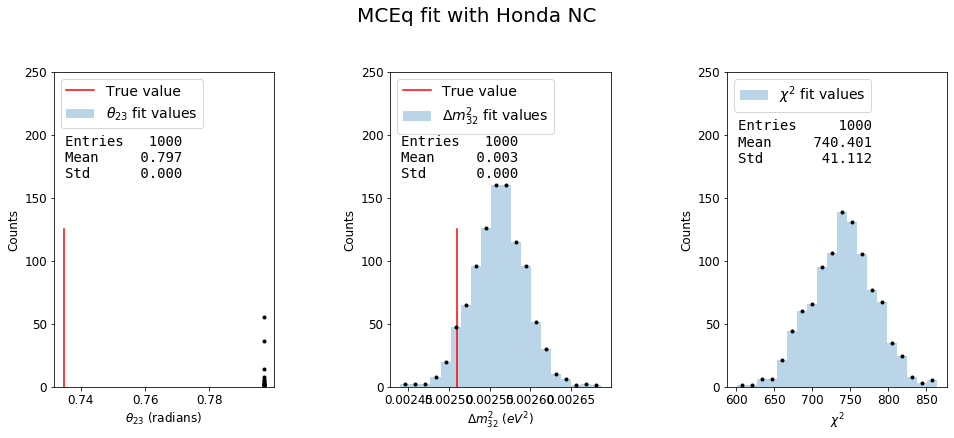

In [173]:
theta23_fits_MCEqtoHonda_nc, theta23_mean_MCEqtoHonda_nc, theta23_std_MCEqtoHonda_nc, DM32_fits_MCEqtoHonda_nc, \
DM32_mean_MCEqtoHonda_nc, DM32_std_MCEqtoHonda_nc = fit_hist(1000, \
                                                    [Honda_rate_nc], \
                                                    [MCEq_pseudo_data_nc], \
                                                    'MCEq fit with Honda NC')